In [1]:
import numpy as np
from datetime import datetime
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
from dataset import Asbest_segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import rawpy
import segmentation_models_pytorch as smp
from utils import parse_anno_file, create_mask_file, big_image_predict, get_time, true_results, get_pz_quantils, get_h, get_quartiles
from apex import amp

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
def calculate_info(img_pathes, model, thresh=0.5):
    results = []
    size = 1024
    for obj in img_pathes:
        img = cv2.imread(obj, cv2.IMREAD_UNCHANGED)
        img, st, asb = big_image_predict(model, 
                                         img,
                                         crop_size=(size, size),
                                         inp_size=(size, size),
                                         device=device
                                        )
        results.append(len(np.where(asb > thresh)[0]) / img.shape[0] / img.shape[1])
    return results

In [3]:
path = 'asbestos/stones'

data = {
    '020221' : 
    { 
        1 : 
        {
            'state' : 'accepted',
            'content' : 0.030,
            'n' : 5, 
            'sort_images' : {},
            'res' : {},
            'images' : 
            { 0 : 
             [
                'asbestos/stones/020221/ManualDetailedImage_12_04_45f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_05_01_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_06_30f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_07_14_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_08_07f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_08_29_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_09_38f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_09_52_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_11_17f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_11_32_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_13_48f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_14_01_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_15_13f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_15_45_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_17_26f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_17_46_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_19_00f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_19_17_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_23_52f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_24_11_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_25_15f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_25_24_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_27_03f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_27_48_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_31_20f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_32_00_300.bmp'
             ]
            },
        },
        2 : 
        { 
            'state' : 'accepted',
            'content' : 0.015,
            'n' : 6, 
            'sort_images' : {},
            'res' : {},
            'images' : 
            { 0 :
            [
                 'asbestos/stones/020221/ManualDetailedImage_12_47_38f_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_49_13_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_51_54f_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_52_28_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_55_14f_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_55_48_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_58_06f_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_58_51_150.bmp'
            ]
            }
        }
    },
    '161220': 
     { 
         2 : 
         { 
             'state' : 'declined',
             'content' : 0.02,
             'n' : 2,
             'sort_images' : {},
             'res' : {},
             'images' :
             { 0 :
             [
                 'asbestos/stones/161220/ManualDetailedImage_10_01_52.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_03_00.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_03_35.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_04_15.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_05_20.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_05_58.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_06_46.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_07_31.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_10_10.bmp',
                 'asbestos/stones/161220/ManualGeneralImage_10_01_26.bmp'
             ]
             }
         },
         3 : 
         { 
             'state' : 'declined',
             'content' : 0.02,
             'n' : 3,
             'sort_images' : {},
             'res' : {},
             'images' :
             { 0 :
             [
                 'asbestos/stones/161220/ManualDetailedImage_10_26_43.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_27_18.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_27_30.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_27_58.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_29_22.bmp',
             ]
             },
         },
         4: 
         { 
             'state' : 'accepted',
             'content' : 0.04,
             'n' : 4,
             'sort_images' : {},
             'res' : {},
             'images' : 
             { 1 :
             [
                 'asbestos/stones/161220/ManualDetailedImage_11_03_34.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_04_07.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_05_06.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_05_43.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_06_02.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_06_30.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_07_12.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_07_55.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_08_37.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_09_00.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_09_20.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_09_58.bmp'
             ],
             }
         },
         1: 
         {
             'state' : 'accepted',
             'content' : 0.02,
             'n' : 1,
             'sort_images' : {},
             'res' : {},
             'images' : {
                 0 :
             [
                  'asbestos/stones/161220/ManualGeneralImage_09_27_13.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_30_19.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_31_25.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_32_23.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_35_25.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_35_52.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_36_12.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_36_44.bmp'
             ]
             }
         }
     },
    '230321' : 
    { 1 : 
     { 
         'state' : 'declined',
         'content' : 0.025,
         'n' : 7,
         'sort_images' : {},
         'res' : {},
         'images' : {
#              1 : [
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-18_1_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-29_2_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-37_3_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-46_4_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-51_5_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-16-24_8_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-16-37_9_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-16-48_10_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-17-04_11_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-17-49_14_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-18-01_15_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-19-36_22_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-19-51_23_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-20-42_28_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-21-05_30_1_detailed.bmp',
#          ],
#              2 : [
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-39-39_1_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-39-55_2_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-01_3_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-09_4_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-19_5_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-29_6_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-35_7_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-47_8_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-55_9_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-41-11_10_1_detailed.bmp',
#              ]
                    },
     },
     2 : 
     { 
         'state' : 'declined',
         'content' : 0.035,
         'n' : 8,
         'sort_images' : {},
         'res' : {},
         'images' : {},
     },
     3 : 
     { 
         'state' : 'accepted',
         'content' : 0.025,
         'n' : 9,
         'sort_images' : {},
         'res' : {},
         'images' : {},
     }
    },
    '200421' : 
    {
        1 : 
        {
            'state' : 'declined',
            'content' : 0.04,
             'n' : 10,
             'sort_images' : {},
             'res' : {},
             'images' : {},
        },
        2 : 
        {
            'state' : 'accepted',
            'content' : 0.025,
             'n' : 11,
             'sort_images' : {},
             'res' : {},
             'images' : {},
        },
        3 : 
        {
            'state' : 'accepted',
            'content' : 0.015,
             'n' : 12,
             'sort_images' : {},
             'res' : {},
             'images' : {},
        },
    },
    '270421' :
    {
        1 : 
        {
            'state' : 'accepted',
            'content' : 0.015,
            'n' : 13,
            'sort_images' : {},
            'res' : {},
            'images' : {},
        },
        2 : 
        {
            'state' : 'accepted',
            'content' : 0.025,
            'n' : 14,
            'sort_images' : {},
            'res' : {},
            'images' : {},
        },
        3 : 
        {
            'state' : 'accepted',
            'content' : 0.04,
            'n' : 15,
            'sort_images' : {},
            'res' : {},
            'images' : {},
        },
        4 : 
        {
            'state' : 'accepted',
            'content' : 0.025,
            'n' : 16,
            'sort_images' : {},
            'res' : {},
            'images' : {},
        }
    }
}

In [4]:
for pit in os.listdir(os.path.join(path, '230321')):
    for i, case in enumerate(os.listdir(os.path.join(path, '230321', pit))):
        data['230321'][int(pit)]['images'][i] =  sorted([os.path.join(path, '230321', pit, case, file) for file in os.listdir(os.path.join(path, '230321', pit, case)) if file.endswith('detailed.bmp')])

for date in ['200421', '270421']:        
    for pit in os.listdir(os.path.join(path, date)):
        for i, case in enumerate(os.listdir(os.path.join(path, date, pit))):
            data[date][int(pit)]['images'][i] =  sorted([os.path.join(path, date, pit, case, 'Detailed', file) for file in os.listdir(os.path.join(path, date, pit, case, 'Detailed')) if file.endswith('detailed.bmp')])

In [5]:
device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

model_asbest = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)
model_asbest.load_state_dict(torch.load('asbest_segmentation_b3_v1.3.pth'))
model_asbest.eval();

In [ ]:
for date in tqdm(data.keys(), total=len(data.keys())):
    for pit in data[date].keys():
        for ind in data[date][pit]['images'].keys():
            res = calculate_info(np.array(data[date][pit]['images'][ind]), model_asbest, thresh=0.5)
            indexes = np.argsort(res)[::-1]
            data[date][pit]['sort_images'][ind] = list(np.array(data[date][pit]['images'][ind])[indexes])
            data[date][pit]['res'][ind] = list(np.array(res)[indexes])

 40%|████      | 2/5 [01:34<02:21, 47.20s/it]

In [ ]:
date = '270421'
pit = 3
scene = 1
ind = 2

img = cv2.imread(data[date][pit]['sort_images'][scene][ind], cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(img)
_, _, asb = big_image_predict(model_asbest, img, crop_size=(1024,1024), inp_size=(1024,1024), device=device)
plt.subplot(132)
plt.imshow(asb)
plt.subplot(133)
plt.hist(img.ravel(), bins=100);
print(np.sum(asb > 0.5) / asb.shape[0] / asb.shape[1])
print('Концентрация: {:.2f}%'.format(100*data[date][pit]['content']))

0.012315349814332561
Концентрация: 1.50%


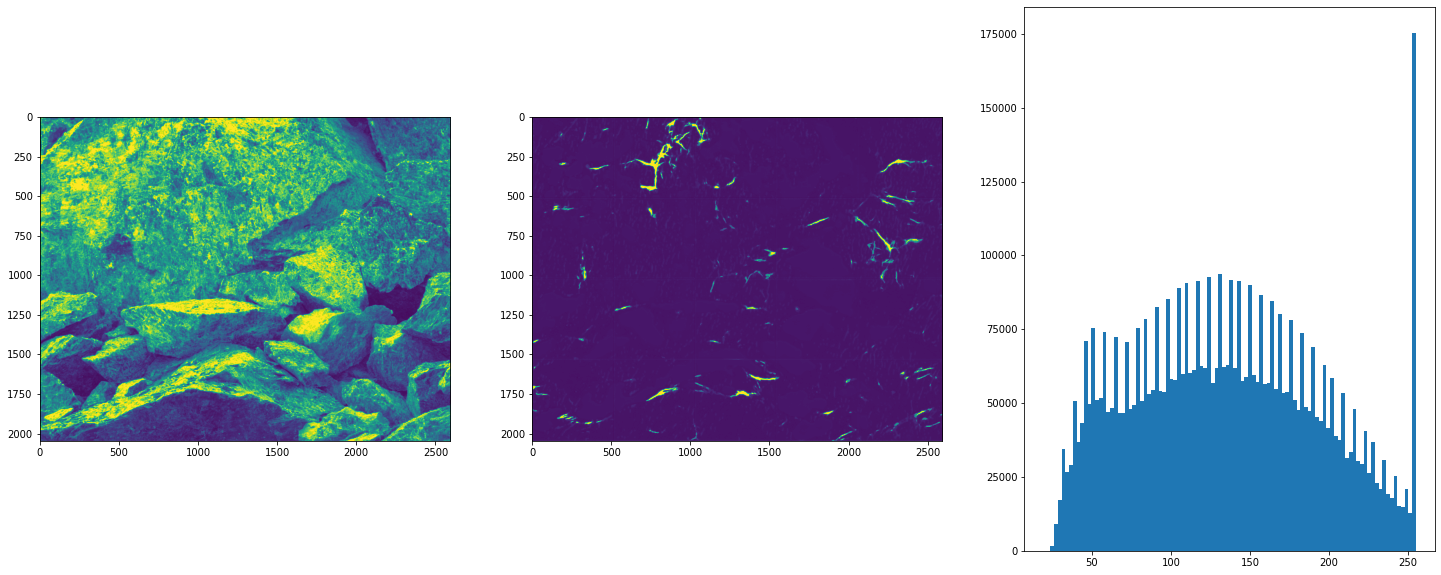

In [27]:
date = '270421'
pit = 1
scene = 1
ind = 3

img = cv2.imread(data[date][pit]['sort_images'][scene][ind], cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(img)
_, _, asb = big_image_predict(model_asbest, img, crop_size=(1024,1024), inp_size=(1024,1024), device=device)
plt.subplot(132)
plt.imshow(asb)
plt.subplot(133)
plt.hist(img.ravel(), bins=100);
print(np.sum(asb > 0.5) / asb.shape[0] / asb.shape[1])
print('Концентрация: {:.2f}%'.format(100*data[date][pit]['content']))

1.5043847354841822
Концентрация: 1.50%


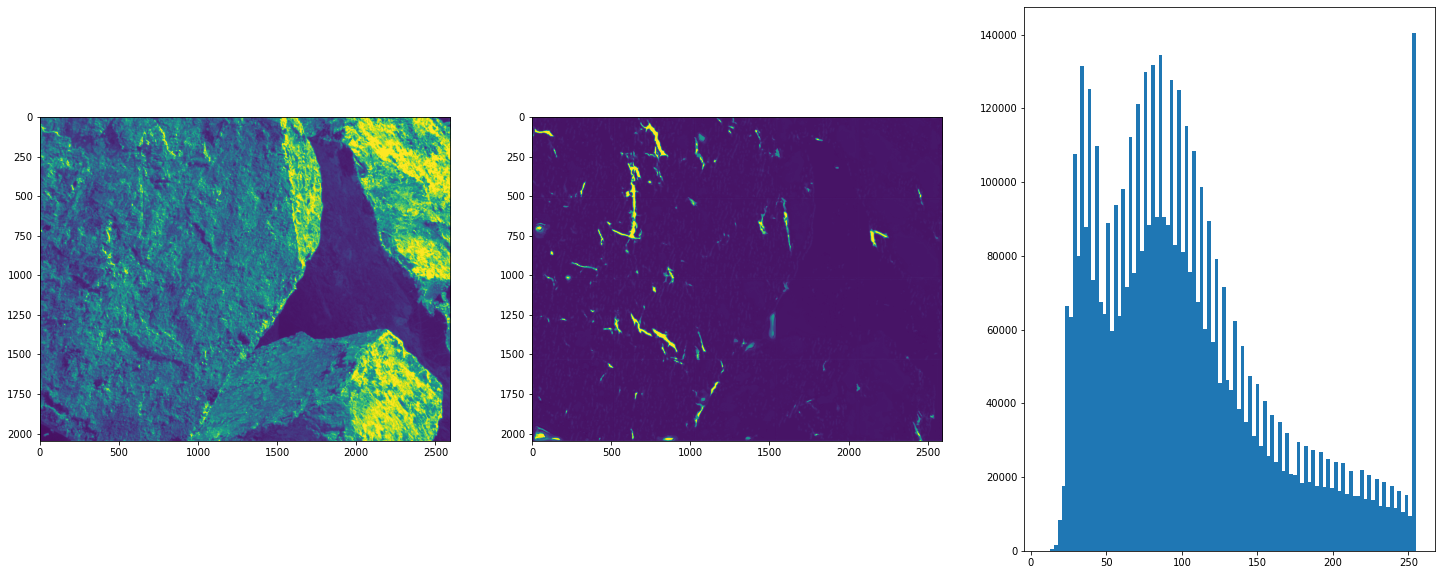

In [56]:
date = '200421'
pit = 3
scene = 0
ind = 2

img = cv2.imread(data[date][pit]['sort_images'][scene][ind], cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(img)
_, _, asb = big_image_predict(model_asbest, img, crop_size=(1024,1024), inp_size=(1024,1024), device=device)
plt.subplot(132)
plt.imshow(asb)
plt.subplot(133)
plt.hist(img.ravel(), bins=100);
print(100*np.sum(asb > 0.5) / asb.shape[0] / asb.shape[1])
print('Концентрация: {:.2f}%'.format(100*data[date][pit]['content']))

5.144114553192516
Концентрация: 2.00%


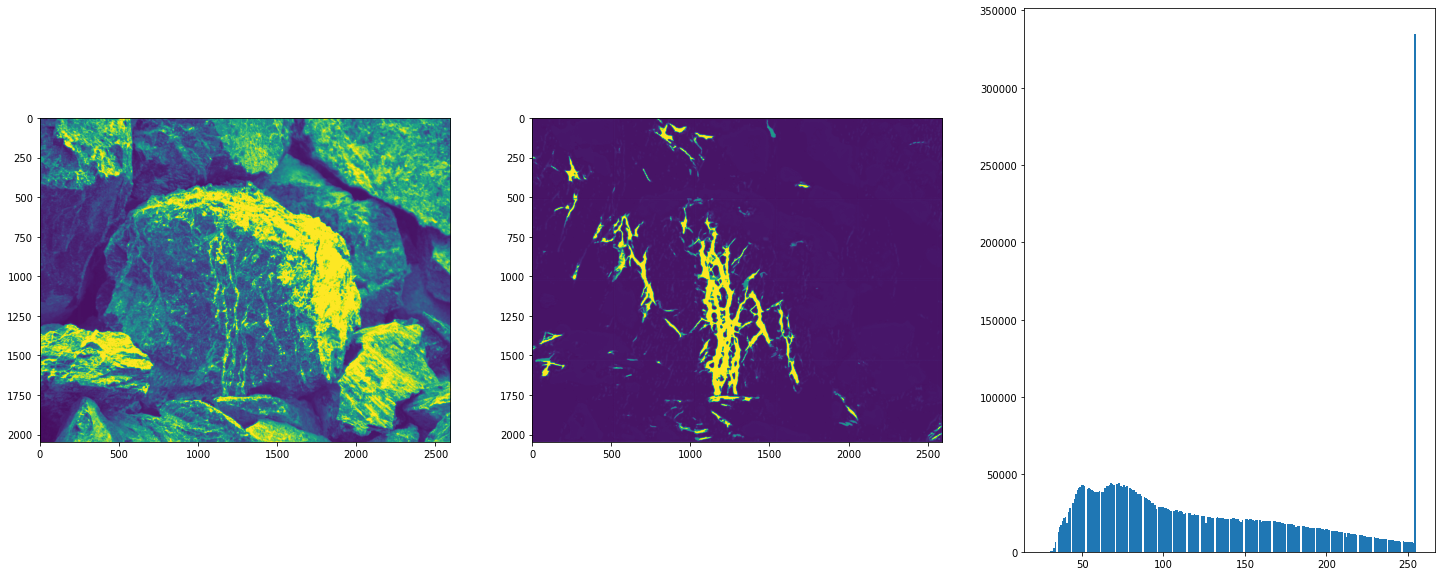

In [57]:
date = '161220'
pit = 2
scene = 0
ind = 0

img = cv2.imread(data[date][pit]['sort_images'][scene][ind], cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(img)
_, _, asb = big_image_predict(model_asbest, img, crop_size=(1024,1024), inp_size=(1024,1024), device=device)
plt.subplot(132)
plt.imshow(asb)
plt.subplot(133)
plt.hist(img.ravel(), bins=255);
print(100*np.sum(asb > 0.5) / asb.shape[0] / asb.shape[1])
print('Концентрация: {:.2f}%'.format(100*data[date][pit]['content']))

1.8741748951099537
Концентрация: 2.00%


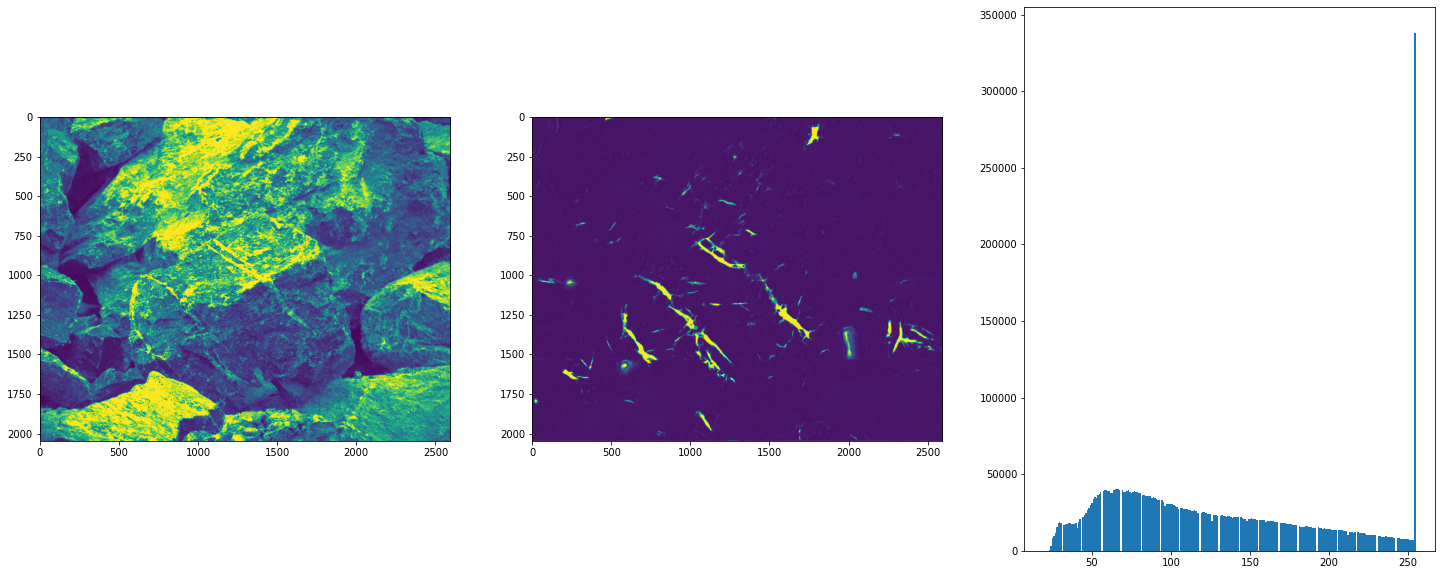

In [58]:
date = '161220'
pit = 1
scene = 0
ind = 0

img = cv2.imread(data[date][pit]['sort_images'][scene][ind], cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(img)
_, _, asb = big_image_predict(model_asbest, img, crop_size=(1024,1024), inp_size=(1024,1024), device=device)
plt.subplot(132)
plt.imshow(asb)
plt.subplot(133)
plt.hist(img.ravel(), bins=255);
print(100*np.sum(asb > 0.5) / asb.shape[0] / asb.shape[1])
print('Концентрация: {:.2f}%'.format(100*data[date][pit]['content']))

4.523194866415895
Концентрация: 4.00%


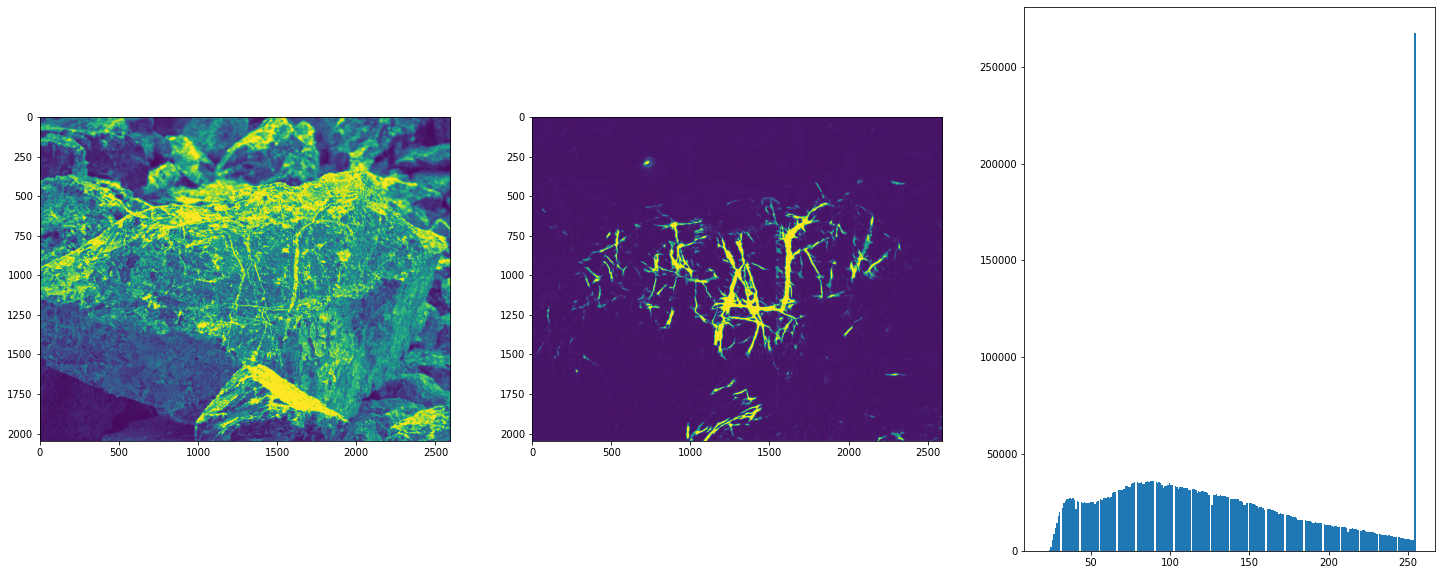

In [59]:
date = '161220'
pit = 4
scene = 1
ind = 0

img = cv2.imread(data[date][pit]['sort_images'][scene][ind], cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(img)
_, _, asb = big_image_predict(model_asbest, img, crop_size=(1024,1024), inp_size=(1024,1024), device=device)
plt.subplot(132)
plt.imshow(asb)
plt.subplot(133)
plt.hist(img.ravel(), bins=255);
print(100*np.sum(asb > 0.5) / asb.shape[0] / asb.shape[1])
print('Концентрация: {:.2f}%'.format(100*data[date][pit]['content']))

1.9020928276909723
Концентрация: 2.50%


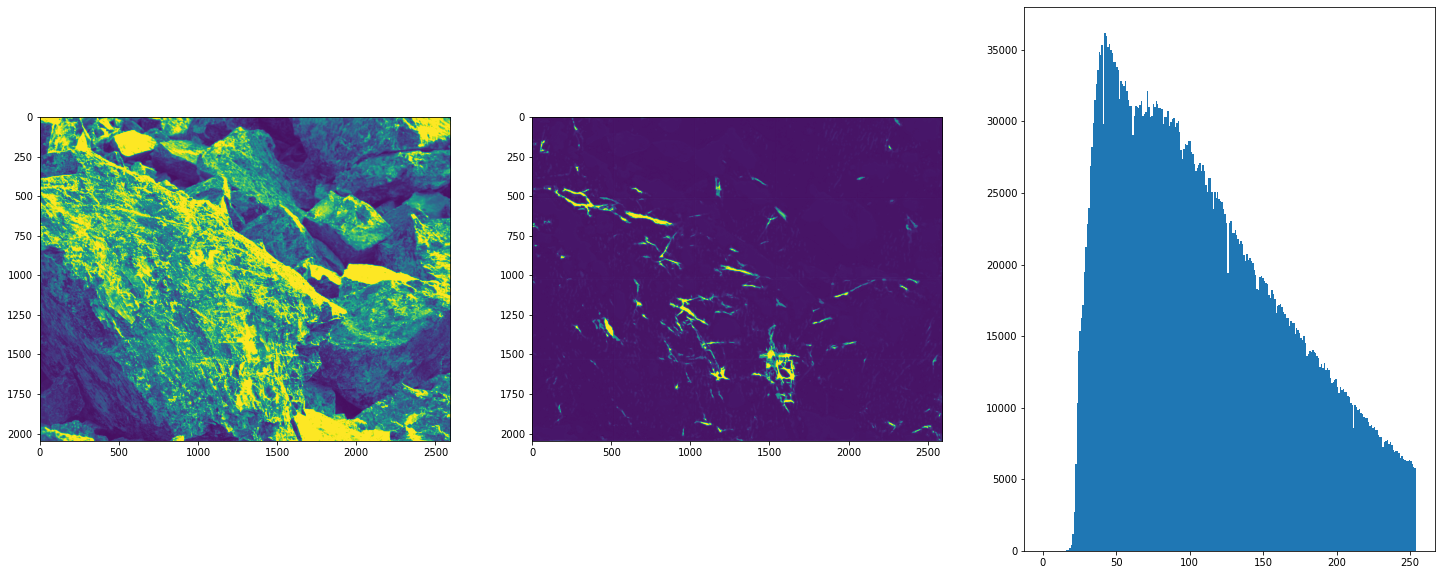

In [61]:
date = '230321'
pit = 1
scene = 0
ind = 0

img = cv2.imread(data[date][pit]['sort_images'][scene][ind], cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(img)
_, _, asb = big_image_predict(model_asbest, img, crop_size=(1024,1024), inp_size=(1024,1024), device=device)
plt.subplot(132)
plt.imshow(asb)
plt.subplot(133)
plt.hist(img.ravel(), range=[0,254], bins=255);
print(100*np.sum(asb > 0.5) / asb.shape[0] / asb.shape[1])
print('Концентрация: {:.2f}%'.format(100*data[date][pit]['content']))

1.3421706211419753
Концентрация: 3.50%


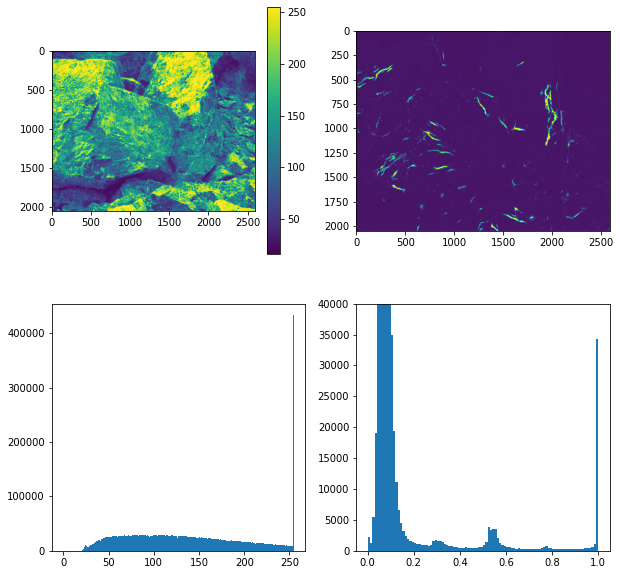

In [72]:
#### date = '230321'
pit = 2
scene = 0
ind = 1

img = cv2.imread(data[date][pit]['sort_images'][scene][ind], cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(img)
plt.colorbar()
# _, _, asb = big_image_predict(model_asbest, img, crop_size=(1024,1024), inp_size=(1024,1024), device=device)
plt.subplot(222)
plt.imshow(asb)
plt.subplot(223)
plt.hist(img.ravel(), range=[0,255], bins=255);
plt.subplot(224)
plt.hist(asb.ravel(), bins=100)
plt.ylim(0, 4e+4)
print(100*np.sum(asb > 0.5) / asb.shape[0] / asb.shape[1])
print('Концентрация: {:.2f}%'.format(100*data[date][pit]['content']))